In [ ]:
if __name__ == '__main__':
    # read in left and right images as RGB images
    img_left = cv2.imread('./left.bmp', 1)
    img_right = cv2.imread('./right.bmp', 1)
    visualize_img_pair(img_left, img_right)

    # Step 1: find correspondences between image pair
    pts1, pts2 = find_match(img_left, img_right)
    visualize_find_match(img_left, img_right, pts1, pts2)

    # Step 2: compute fundamental matrix
    F = compute_F(pts1, pts2)
    visualize_epipolar_lines(F, pts1, pts2, img_left, img_right)

    # Step 3: computes four sets of camera poses
    K = np.array([[350, 0, 960/2], [0, 350, 540/2], [0, 0, 1]])
    Rs, Cs = compute_camera_pose(F, K)
    visualize_camera_poses(Rs, Cs)

    # Step 4: triangulation
    pts3Ds = []
    P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
    for i in range(len(Rs)):
        P2 = K @ np.hstack((Rs[i], -Rs[i] @ Cs[i]))
        pts3D = triangulation(P1, P2, pts1, pts2)
        pts3Ds.append(pts3D)
    visualize_camera_poses_with_pts(Rs, Cs, pts3Ds)

    # Step 5: disambiguate camera poses
    R, C, pts3D = disambiguate_pose(Rs, Cs, pts3Ds)

    # Step 6: rectification
    H1, H2 = compute_rectification(K, R, C)
    img_left_w = cv2.warpPerspective(img_left, H1, (img_left.shape[1], img_left.shape[0]))
    img_right_w = cv2.warpPerspective(img_right, H2, (img_right.shape[1], img_right.shape[0]))
    visualize_img_pair(img_left_w, img_right_w)

    # Step 7: generate disparity map
    img_left_w = cv2.resize(img_left_w, (int(img_left_w.shape[1] / 2), int(img_left_w.shape[0] / 2)))  # resize image for speed
    img_right_w = cv2.resize(img_right_w, (int(img_right_w.shape[1] / 2), int(img_right_w.shape[0] / 2)))
    img_left_w = cv2.cvtColor(img_left_w, cv2.COLOR_BGR2GRAY)  # convert to gray scale
    img_right_w = cv2.cvtColor(img_right_w, cv2.COLOR_BGR2GRAY)
    disparity = dense_match(img_left_w, img_right_w)
    visualize_disparity_map(disparity)

    # save to mat
    sio.savemat('stereo.mat', mdict={'pts1': pts1, 'pts2': pts2, 'F': F, 'pts3D': pts3D, 'H1': H1, 'H2': H2,
                                     'img_left_w': img_left_w, 'img_right_w': img_right_w, 'disparity': disparity})


In [1]:
import cv2
import numpy as np
import scipy.io as sio
from scipy.linalg import null_space
import matplotlib.pyplot as plt
import sys
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D

In [2]:
img_left = cv2.imread('./left.bmp', 1)
img_right = cv2.imread('./right.bmp', 1)

In [26]:
def visualize_img_pair(img1, img2):
    img = np.hstack((img1, img2))
    if img1.ndim == 3:
        fig = plt.figure(figsize=(16,16))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

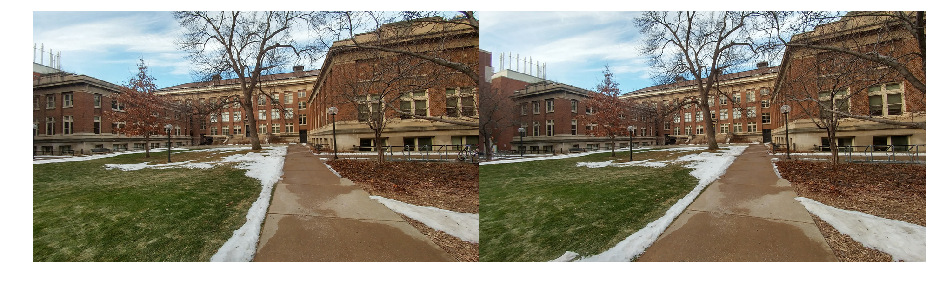

In [27]:
visualize_img_pair(img_left, img_right)

In [10]:
def get_SIFT(template):
    sift = cv2.xfeatures2d.SIFT_create()
    kp, desc = sift.detectAndCompute(template, None)
    return cv2.KeyPoint_convert(kp), desc

In [13]:
def switch_x_y(array_xy):
    array_yx = [0,0]
    array_yx[0] = array_xy[1]
    array_yx[1] = array_xy[0]
    return array_yx

In [14]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3

In [279]:
def find_match(img1, img2, tolerate_rate = 0.7):
    sift_1 = get_SIFT(img1)
    sift_2 = get_SIFT(img2)
    neigh = NearestNeighbors(2, 0.4)
    neigh.fit(sift_2[1])
    x1_to_x2 = []
    for i in range(sift_1[0].shape[0]):
        tmp_fit_point = neigh.kneighbors([sift_1[1][i,:]], 2, return_distance=True)
        if(tmp_fit_point[0][0][0]/tmp_fit_point[0][0][1]<tolerate_rate):
            x1_to_x2.append([i,tmp_fit_point[1][0][0]])
    neigh.fit(sift_1[1])
    x2_to_x1 = []
    for i in range(sift_2[0].shape[0]):
        tmp_fit_point = neigh.kneighbors([sift_2[1][i,:]], 2, return_distance=True)
        if(tmp_fit_point[0][0][0]/tmp_fit_point[0][0][1]<tolerate_rate):
            x2_to_x1.append([i,tmp_fit_point[1][0][0]])
    x2_to_x1_inv = list(map(lambda x: switch_x_y(x),x2_to_x1))
    common_list = intersection(x1_to_x2,x2_to_x1_inv)
    x1 = []
    x2 = []
    for item in common_list:
        x1.append(sift_1[0][item[0],:])
        x2.append(sift_2[0][item[1],:])
    return np.array(x1), np.array(x2)

In [280]:
pts1, pts2 = find_match(img_left, img_right)

In [226]:
def visualize_find_match(img1, img2, pts1, pts2):
    assert pts1.shape == pts2.shape, 'x1 and x2 should have same shape!'
    img_h = img1.shape[0]
    scale_factor1 = img_h/img1.shape[0]
    scale_factor2 = img_h/img2.shape[0]
    img1_resized = cv2.resize(img1, None, fx=scale_factor1, fy=scale_factor1)
    img2_resized = cv2.resize(img2, None, fx=scale_factor2, fy=scale_factor2)
    pts1 = pts1 * scale_factor1
    pts2 = pts2 * scale_factor2
    pts2[:, 0] += img1_resized.shape[1]
    img = np.hstack((img1_resized, img2_resized))
    fig = plt.figure(figsize=(16,16))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    for i in range(pts1.shape[0]):
        plt.plot([pts1[i, 0], pts2[i, 0]], [pts1[i, 1], pts2[i, 1]], 'b.-', linewidth=0.5, markersize=5)
    plt.axis('off')
    plt.show()

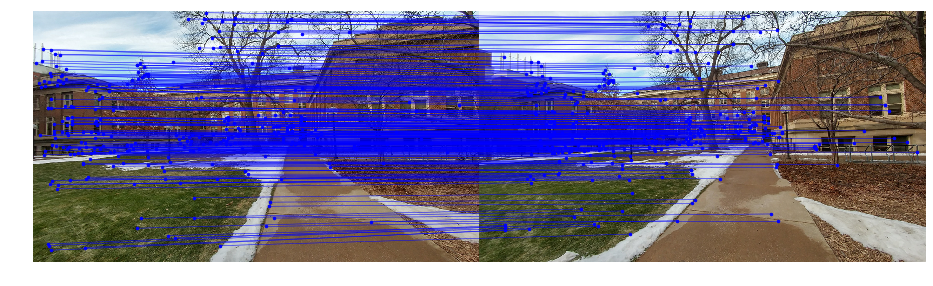

In [281]:
visualize_find_match(img_left, img_right, pts1, pts2)

In [266]:
def SVD_cleanup(Mat):
    u, s, vh = np.linalg.svd(Mat)
    S = np.diag(s)
    S[-1,-1] = 0.0
    clean_Mat = np.dot(u,np.dot(S,vh))
    return clean_Mat

In [723]:
def compute_F(pts1, pts2, ransac_thr = 1, ransac_iter = 1000):
    np.random.seed(5561)
    max_include_num = 0
    F = np.zeros(shape=(3,3))
    for times in range(ransac_iter):
        random_select_list = list(np.random.choice(range(pts1.shape[0]), size=8, replace=False))
        mat_A = np.zeros(shape=(8,9))
        for i in range(8):
            point = random_select_list[i]
            x_u,y_u = pts1[point,0],pts1[point,1]
            x_v,y_v = pts2[point,0],pts2[point,1]
            A_list = [x_u*x_v, y_u*x_v, x_v, x_u*y_v, y_u*y_v, y_v, x_u, y_u, 1]
            mat_A[i] = np.mat(A_list)
        x_sol = null_space(mat_A)
        if (x_sol.shape[1] != 1):
            x_sol = x_sol[:,0]
        tmp_F = x_sol.reshape((3,3))
        tmp_F_clean = SVD_cleanup(tmp_F)
        include_counter = 0
        for j in range(pts1.shape[0]):
            v_point = np.ones(shape=(3,1))
            v_point[0,0] = pts2[j,0]
            v_point[1,0] = pts2[j,1]
            u_point = np.ones(shape=(3,1))
            u_point[0,0] = pts1[j,0]
            u_point[1,0] = pts1[j,1]
            rst = np.dot(np.dot(v_point.T,tmp_F_clean),u_point)[0][0]
            if (np.abs(rst)<ransac_thr):
                include_counter = include_counter + 1
        #print("The counter number is {} for the {}th iteration.".format(include_counter,times))
        if (include_counter>max_include_num):
            max_include_num = include_counter
            F = tmp_F_clean
    return F

In [724]:
F = compute_F(pts1, pts2)

In [725]:
def find_epipolar_line_end_points(img, F, p):
    img_width = img.shape[1]
    el = np.dot(F, np.array([p[0], p[1], 1]).reshape(3, 1))
    p1, p2 = (0, -el[2] / el[1]), (img.shape[1], (-img_width * el[0] - el[2]) / el[1])
    _, p1, p2 = cv2.clipLine((0, 0, img.shape[1], img.shape[0]), p1, p2)
    return p1, p2

In [726]:
def visualize_epipolar_lines(F, pts1, pts2, img1, img2):
    assert pts1.shape == pts2.shape, 'x1 and x2 should have same shape!'
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

    for i in range(pts1.shape[0]):
        x1, y1 = int(pts1[i][0] + 0.5),int(pts1[i][1] + 0.5)
        ax1.scatter(x1, y1, s=5)
        p1, p2 = find_epipolar_line_end_points(img2, F, (x1, y1))
        ax2.plot([p1[0], p2[0]], [p1[1], p2[1]], linewidth=0.5)

    for i in range(pts2.shape[0]):
        x2, y2 = int(pts2[i][0] + 0.5), int(pts2[i][1] + 0.5)
        ax2.scatter(x2, y2, s=5)
        p1, p2 = find_epipolar_line_end_points(img1, F.T, (x2, y2))
        ax1.plot([p1[0], p2[0]], [p1[1], p2[1]], linewidth=0.5)

    ax1.axis('off')
    ax2.axis('off')
    plt.show()

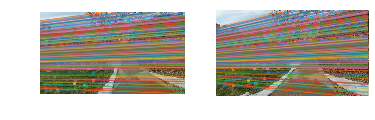

In [727]:
visualize_epipolar_lines(F, pts1, pts2, img_left, img_right)

In [728]:
def compute_camera_pose(F, K):
    E = K.T @ F @ K
    R_1, R_2, t = cv2.decomposeEssentialMat(E)
    # 4 cases
    R1, t1 = R_1, t
    R2, t2 = R_1, -t
    R3, t3 = R_2, t
    R4, t4 = R_2, -t

    Rs = [R1, R2, R3, R4]
    ts = [t1, t2, t3, t4]
    Cs = []
    for i in range(4):
        Cs.append(-Rs[i].T @ ts[i])
    return Rs, Cs

In [729]:
def draw_camera(ax, R, C, scale=0.2):
    axis_end_points = C + scale * R.T  # (3, 3)
    vertices = C + scale * R.T @ np.array([[1, 1, 1], [-1, 1, 1], [-1, -1, 1], [1, -1, 1]]).T  # (3, 4)
    vertices_ = np.hstack((vertices, vertices[:, :1]))  # (3, 5)

    # draw coordinate system of camera
    ax.plot([C[0], axis_end_points[0, 0]], [C[1], axis_end_points[1, 0]], [C[2], axis_end_points[2, 0]], 'r-')
    ax.plot([C[0], axis_end_points[0, 1]], [C[1], axis_end_points[1, 1]], [C[2], axis_end_points[2, 1]], 'g-')
    ax.plot([C[0], axis_end_points[0, 2]], [C[1], axis_end_points[1, 2]], [C[2], axis_end_points[2, 2]], 'b-')

    # draw square window and lines connecting it to camera center
    ax.plot(vertices_[0, :], vertices_[1, :], vertices_[2, :], 'k-')
    ax.plot([C[0], vertices[0, 0]], [C[1], vertices[1, 0]], [C[2], vertices[2, 0]], 'k-')
    ax.plot([C[0], vertices[0, 1]], [C[1], vertices[1, 1]], [C[2], vertices[2, 1]], 'k-')
    ax.plot([C[0], vertices[0, 2]], [C[1], vertices[1, 2]], [C[2], vertices[2, 2]], 'k-')
    ax.plot([C[0], vertices[0, 3]], [C[1], vertices[1, 3]], [C[2], vertices[2, 3]], 'k-')

In [730]:
def set_axes_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range, x_middle = abs(x_limits[1] - x_limits[0]), np.mean(x_limits)
    y_range, y_middle = abs(y_limits[1] - y_limits[0]), np.mean(y_limits)
    z_range, z_middle = abs(z_limits[1] - z_limits[0]), np.mean(z_limits)

    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [731]:
def visualize_camera_poses(Rs, Cs):
    assert(len(Rs) == len(Cs) == 4)
    fig = plt.figure()
    R1, C1 = np.eye(3), np.zeros((3, 1))
    for i in range(4):
        R2, C2 = Rs[i], Cs[i]
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        draw_camera(ax, R1, C1)
        draw_camera(ax, R2, C2)
        set_axes_equal(ax)
        ax.set_xlabel('x axis')
        ax.set_ylabel('y axis')
        ax.set_zlabel('z axis')
        ax.view_init(azim=-90, elev=0)
    fig.tight_layout()
    plt.show()

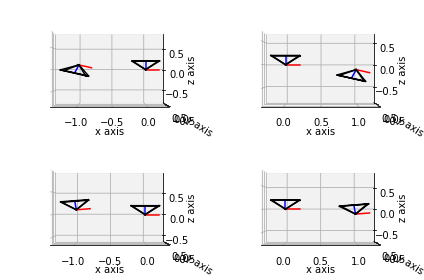

In [732]:
K = np.array([[350, 0, 960/2], [0, 350, 540/2], [0, 0, 1]])
Rs, Cs = compute_camera_pose(F, K)
visualize_camera_poses(Rs, Cs)

In [733]:
def three_dim_skew_symmetric(input_vector):
    a,b,c = input_vector[0,0],input_vector[1,0],input_vector[2,0]
    skew_sym_mat = np.zeros(shape=(3,3))
    skew_sym_mat[0,1] = -c
    skew_sym_mat[0,2] = b
    skew_sym_mat[1,0] = c
    skew_sym_mat[1,2] = -a
    skew_sym_mat[2,0] = -b
    skew_sym_mat[2,1] = a
    return skew_sym_mat

In [734]:
def triangulation(P1, P2, pts1, pts2):
    pts3D = np.zeros(shape=(pts1.shape[0],3))
    for j in range(pts1.shape[0]):
        u_point = np.ones(shape=(3,1))
        u_point[0,0] = pts1[j,0]
        u_point[1,0] = pts1[j,1]
        u_mat = three_dim_skew_symmetric(u_point)
        v_point = np.ones(shape=(3,1))
        v_point[0,0] = pts2[j,0]
        v_point[1,0] = pts2[j,1]
        v_mat = three_dim_skew_symmetric(v_point)
        conc_mat = np.concatenate((np.dot(u_mat,P1)[:2,:], np.dot(v_mat,P2)[:2,:]))
        pts3D_row_sol = np.linalg.svd(conc_mat)[2].T[:,-1]
        pts3D_row = (pts3D_row_sol/pts3D_row_sol[-1])[:-1]
        pts3D[j] = pts3D_row
    return pts3D

In [735]:
def visualize_camera_poses_with_pts(Rs, Cs, pts3Ds):
    assert(len(Rs) == len(Cs) == 4)
    fig = plt.figure()
    R1, C1 = np.eye(3), np.zeros((3, 1))
    for i in range(4):
        R2, C2, pts3D = Rs[i], Cs[i], pts3Ds[i]
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        draw_camera(ax, R1, C1, 5)
        draw_camera(ax, R2, C2, 5)
        ax.plot(pts3D[:, 0], pts3D[:, 1], pts3D[:, 2], 'b.')
        set_axes_equal(ax)
        ax.set_xlabel('x axis')
        ax.set_ylabel('y axis')
        ax.set_zlabel('z axis')
        ax.view_init(azim=-90, elev=0)
    fig.tight_layout()
    plt.show()

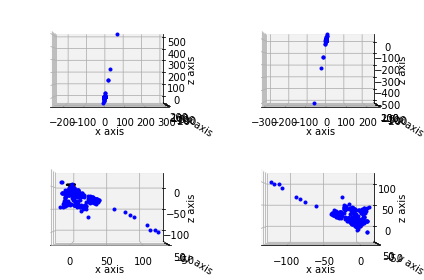

In [736]:
pts3Ds = []
P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
for i in range(len(Rs)):
    P2 = K @ np.hstack((Rs[i], -Rs[i] @ Cs[i]))
    pts3D = triangulation(P1, P2, pts1, pts2)
    pts3Ds.append(pts3D)
visualize_camera_poses_with_pts(Rs, Cs, pts3Ds)

In [737]:
def compute_valid_num(R, C, pts3D):
    nValid = 0
    for j in range(pts1.shape[0]):
        point_verify = np.dot(R[2,:].reshape((1,3)),pts3D[j].reshape((-1,1)) - C)[0][0]
        if (point_verify>0):
            nValid = nValid + 1
    return nValid

In [738]:
def disambiguate_pose(Rs, Cs, pts3Ds):
    max_itr = -1
    max_valid_num = -1
    for i in range(len(Rs)):
        valid_num = compute_valid_num(Rs[i],Cs[i],pts3Ds[i])
        if(valid_num>max_valid_num):
            max_itr = i
            max_valid_num = valid_num
    R, C, pts3D = Rs[max_itr], Cs[max_itr], pts3Ds[max_itr]
    return R, C, pts3D

In [739]:
R, C, pts3D = disambiguate_pose(Rs, Cs, pts3Ds)

In [740]:
def compute_R_rect(C):
    R_rect = np.zeros((3,3))
    r_x = C/np.linalg.norm(C)
    c_z = np.array([[0],[0],[1]])
    tmp_r_z = c_z-np.dot(c_z.T,r_x)*r_x
    r_z = tmp_r_z/np.linalg.norm(tmp_r_z)
    r_y = np.cross(r_z.T,r_x.T).T
    R_rect[0,:] = r_x.T
    R_rect[1,:] = r_y.T
    R_rect[2,:] = r_z.T
    return R_rect

In [741]:
def compute_rectification(K, R, C):
    R_rect = compute_R_rect(C)
    H1 = np.dot(np.dot(K,R_rect),np.linalg.inv(K))
    H2 = np.dot(np.dot(np.dot(K,R_rect),R.T),np.linalg.inv(K))
    return H1, H2

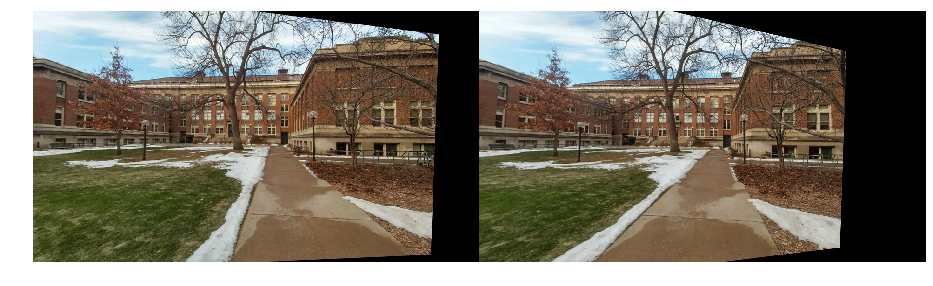

In [841]:
H1, H2 = compute_rectification(K, R, C)
img_left_w = cv2.warpPerspective(img_left, H1, (img_left.shape[1], img_left.shape[0]))
img_right_w = cv2.warpPerspective(img_right, H2, (img_right.shape[1], img_right.shape[0]))
visualize_img_pair(img_left_w, img_right_w)

In [867]:
def compute_dsift(img, stride = 1, size = 5):
    kpts = []
    j_max = int(np.floor((img.shape[0] - 2 * size)/stride))+1
    i_max = int(np.floor((img.shape[1] - 2 * size)/stride))+1
    for j in range(j_max):
        for i in range(i_max):
            kpts.append(cv2.KeyPoint(size+stride*i, size+stride*j, size))
    sift = cv2.xfeatures2d.SIFT_create()
    dense_feature = sift.compute(img, kpts)[1]
    return dense_feature

In [864]:
def compute_point_disp(y,x,dense_img2):
    disp = -1
    min_dense_norm = 10000
    for i in range(dense_feature_img2.shape[1]):
        dense_norm = np.linalg.norm(dense_feature_img1[y][x]-dense_feature_img2[y][i])
        if (dense_norm<min_dense_norm):
            min_dense_norm = dense_norm
            disp = np.abs(x-i)
    return disp

In [870]:
def dense_match(img1, img2):
    dense_feature_img1 = compute_dsift(img1).reshape((img1.shape[0]-9,img1.shape[1]-9,128))
    dense_feature_img2 = compute_dsift(img2).reshape((img2.shape[0]-9,img2.shape[1]-9,128))
    disparity = np.zeros((dense_feature_img1.shape[0],dense_feature_img2.shape[1]))
    for i in range(dense_feature_img1.shape[0]):
        for j in range(dense_feature_img1.shape[1]):
            disparity[i,j] = compute_point_disp(i,j,dense_feature_img2)
    return disparity

In [743]:
def visualize_disparity_map(disparity):
    plt.imshow(disparity, cmap='jet')
    plt.show()

In [842]:
img_left_w = cv2.resize(img_left_w, (int(img_left_w.shape[1] / 2), int(img_left_w.shape[0] / 2)))  # resize image for speed
img_right_w = cv2.resize(img_right_w, (int(img_right_w.shape[1] / 2), int(img_right_w.shape[0] / 2)))

In [843]:
img_left_w = cv2.cvtColor(img_left_w, cv2.COLOR_BGR2GRAY)  # convert to gray scale
img_right_w = cv2.cvtColor(img_right_w, cv2.COLOR_BGR2GRAY)

In [871]:
disparity = dense_match(img_left_w, img_right_w)

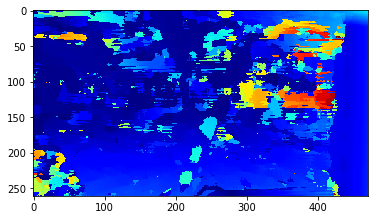

In [872]:
visualize_disparity_map(disparity)

In [874]:
sio.savemat('stereo.mat', mdict={'pts1': pts1, 'pts2': pts2, 'F': F, 'pts3D': pts3D, 'H1': H1, 'H2': H2,'img_left_w': img_left_w, 'img_right_w': img_right_w, 'disparity': disparity})